### Mathieu LAMIOT, Sohyeong KIM

# Chapter 2 : Object Detection and Recognition

In [5]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import glob
%matplotlib inline

## 2.2 Person Detection 

In this section, we will return to the HOG features from the last Chapter. As we said before, HOG was proposed as a useful feature for human detection. If you reach this point, you may have noticed that Template matching may not be the best option for this. Imagine how difficult it would be to create a template for any human-shaped structure that you would like to detect as a human in a scene. Instead of that, you will train a Linear Classifier from scratch. 

Section objectives:

In this section, since you know the basics of HOG, you will use OpenCV's implementation to extract the HOG's features of the curated INRIA's Persons dataset to train an SVM Linear classifier (https://en.wikipedia.org/wiki/Support_vector_machine). For this, instead of using OpenCV's (already trained) classifier, we will use the Scikit-learn Machine Learning library (http://scikit-learn.org). Which is one of the most used machine learning libraries around this days.



## Dataset 

 This dataset was collected as part of the research work on detection of upright people in images and video. The research is described in detail in the CVPR 2005 paper _Histograms of Oriented Gradients for Human Detection_. The full dataset is about ~1 GB and contains several thousands of pedestrian images. 
 
For your convenience, the dataset is already separated into two sets: 
* " **_Positives_**" which are all the images containing at least one person. 
* "**_Negatives_**" any kind of non-human shaped objects images.

In addition, the data is already separated in a **training** and **testing** set (seriously, it cannot be more conveniently done).

Link:  <a ref=ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar> ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar </a>



In [6]:
# Download the Data
# The following functions will download the data for you and uncompress it

url = ' ftp://ftp.inrialpes.fr/pub/lear/douze/data/'
data_root = '../data/'

def maybe_download(filename, expected_bytes, force=False):
  """
  Downloads a file if not present, and make sure it's the right size!.
  If there's a file with the same name, the function will not try to 
  download the data set again!
  """

  dest_filename = os.path.join(data_root, filename)
    
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename, 'This may take a while. Please wait.') 
    filename, _ = urlretrieve(url + filename, dest_filename)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'The file ' + dest_filename + 'already exist but seems corrupted. Delete it or download it from the browser!')
  return dest_filename


def maybe_extract(filename, force=False):
  """
  Uncompress the data set for you
  """
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    tar.extractall(data_root)
    tar.close()
    
  print("All setup.")


dataset_tar = maybe_download('INRIAPerson.tar', 1016094720)

dataset = maybe_extract(dataset_tar)



Found and verified ../data/INRIAPerson.tar
../data/INRIAPerson dataset (seems to be) already present.
Skipping extraction of ../data/INRIAPerson.tar.
All setup.


In [7]:
# Retrieve the negative images files 
# Since the downloaded folder was empty we had to do get the images manually.

# Training data
with open('../data/INRIAPerson/train_64x128_H96/neg.lst') as f:
    content = f.readlines()

content = [x.strip() for x in content]
content = [x.replace('train/neg/','') for x in content]
neg_files = content

# Testing data
with open('../data/INRIAPerson/test_64x128_H96/neg.lst') as f:
    content_test = f.readlines()

content_test = [x.strip() for x in content_test]
content_test = [x.replace('test/neg/','') for x in content_test]
neg_files_test = content_test

If you have problems running the functions above, you can download manually the dataset from the link provided above and uncompress it in your _data_ directory.
<br>

Once you have the data, you will now process each image on both: _positive_ and _negative_ folders using the OpenCV HOG Descriptor implementation: 

https://docs.opencv.org/2.4/modules/gpu/doc/object_detection.html


Your job: Using the skeleton provided below, for each image in the "pos" and "neg" folder of the *training* set:

* Compute the hog feature vector using the parameters provided below. 
    * The length of each individual feature vector should be of 16800. Derive bellow why is of this size. (Hint: Imagine that you have an image of size (32,32) which would be the size of this case?).
   
* Append the feature vector to the _training_feature_ list.
    * The total size of this list should be of (16800, number of images in your training set). 

* For each image add to the _label_ vector a 1 if it's positive or 0 if it's negative. The final length of the _labels_ should be the number of images in your full training set.

WARNING: The dataset may contain corrupted images. Be sure, inside your code, to check if the image was loaded properly. Otherwise, you will get either trash features or execution errors.



The length of each individual feature vector should be of 16800. Derive bellow why is of this size.

** Your answers **

- The 64 x 128 pixel detection window will be divided into 7 blocks across and 15 blocks vertically, for a total of 105 blocks. Each block contains 16 cells with a 10-bin histogram for each cell, for a total of 160 values per block. This brings the final vector size to 7 blocks across  ×  15 blocks vertically  ×  16 cells per block  ×  10-bins per histogram = 16800 values.

In [8]:
## Training set:

#Positive folder:
pos_im_path = "../data/INRIAPerson/train_64x128_H96/pos/"

#Negative folder:
#neg_im_path = "../data/INRIAPerson/train_64x128_H96/neg/"
neg_im_path = "../data/INRIAPerson/train/neg/"

# Window size: this specifies the size of the input image (remember to scale the input to this size!)
winSize     = (64,128)

# Size on pixels of each block (remember that a block contains a set of CELLS)
blockSize   = (16,16)

# The separation between each block. If this value is less than the block size, 
# there will be overlapping blocks. 
block_stride = (8,8)

# The size of each CELL. Each cell computes one histogram. The cells should FIT inside a block.
cellSize = (4,4)

# Number of bins for each histogram.
nbins = 10

# hog is an instance taht contains the info and is able to compute the feature vector.
hog = cv2.HOGDescriptor(winSize,blockSize,block_stride,cellSize, nbins)

# list to save ALL the features.
training_features = []

# Auxiliary array to label each features if it comes from a "positive"(1) or "negative" (0) image.
labels = []

print ("Calculating the descriptors for the positive samples and saving them")

Calculating the descriptors for the positive samples and saving them


In [9]:
# CODE here.

import imageio

pos_files = os.listdir(pos_im_path)
neg_files = content

print ("Calculating the descriptors for the positive samples and saving them")
for file in  pos_files:
    img_raw = imageio.imread(os.path.join(pos_im_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    labels.append(1)
    training_features.append(hog.compute(real_img,winSize))
    
print ("Calculating the descriptors for the negative samples and saving them")
for file in  neg_files:
    img_raw = cv.imread(os.path.join(neg_im_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    labels.append(0)
    training_features.append(hog.compute(real_img,winSize))
    
print('Done')


Calculating the descriptors for the positive samples and saving them
Calculating the descriptors for the negative samples and saving them
Done


Now that you have this features computed and saved in a feature matrix, you are pretty much set to train a classifier. 

scikit-learn provides all the implementation needed to train a linear classifier with no more than 2 lines of code! (Which is awesome and sad at the same time). 

For this exercise, you will use a Linear Support Vector Classifier. 

http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Please take the time to read the implementation details, but more importantly, the examples and theory provided in the documentation. If you are not interested in knowing stuff, you can jump right away to use the implemented functions in the block below.

In [10]:
# Training the classifier.

# Check the dimentions fits
print (np.array(training_features).shape,len(labels))
# (3634, 16800, 1) 3634


# create a LINEAR classifier instance here (LinearSVC): 
LinearClassifier = LinearSVC(random_state=0)

#train the classifier (LinearSVC.fit).
print ("Training a Linear SVM Classifier")
LinearClassifier.fit(np.array(training_features)[:,:,0], labels)

print('Done')

(3634, 16800, 1) 3634
Training a Linear SVM Classifier
Done


After training the classifier -which a fancy way to say that you fitted a 1-D vector of coefficients!- you can use this Support Vector Machine to *classify* if, given an input * HOG feature vector* (with strictly the same dimensions as your training data), it came from an image with a human-shaped form in it (prediction = 1), or not (prediction = 0).

*Your job*:

For each image in the test folders: 
* Compute the HOG feature vector.
* Predict/classify the vector as positive (1) or negative (0); Hint: LinearSCV.predict(...)
* Compute the estimation error for the negative and positive images _separetely_.
* Compute and report the F1-score https://en.wikipedia.org/wiki/F1_score

In [11]:
test_pos_path = "../data/INRIAPerson/test_64x128_H96/pos/"

positive_prediction=[]
print ("Estimating the test data [Positive samples]")
for file in os.listdir(test_pos_path):
    img_raw = imageio.imread(os.path.join(test_pos_path,file))
    img = cv.resize(img_raw,winSize)
    real_img = img[:,:,0:3]
    hog_ut = hog.compute(real_img,winSize);
    hog_ut_list = hog_ut.flatten().reshape(1, -1)
    positive_prediction.append(LinearClassifier.predict(hog_ut_list));

Estimation_Positive = sum(positive_prediction)/len(positive_prediction);  
print('Success rate of positive is', float(Estimation_Positive))
print("Done")

Estimating the test data [Positive samples]
Success rate of positive is 0.8907637655417406
Done


In [12]:
test_neg_path = "../data/INRIAPerson/test/neg/"

print ("Estimating the test data [Negative samples]")
negative_prediction = []
for file in neg_files_test:
    img_raw = cv.imread(os.path.join(test_neg_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    hog_ut = hog.compute(real_img,winSize);
    hog_ut_list = hog_ut.flatten().reshape(1, -1)
    negative_prediction.append(LinearClassifier.predict(hog_ut_list));

Estimation_Negative = sum(negative_prediction)/len(negative_prediction);    
print('Error rate of negative is', float(Estimation_Negative))
print("Done")


Estimating the test data [Negative samples]
Error rate of negative is 0.019867549668874173
Done


In [13]:
precision = sum(positive_prediction)/(sum(positive_prediction)+sum(negative_prediction))
recall = sum(positive_prediction)/len(positive_prediction); 
F1_score = 2*(precision)*recall/(precision+recall)
print('F1_score', float(F1_score))

F1_score 0.9382600561272216


The basic classifier above can (should) achieve a success rate of 89% for the positive and less than 2% error for the negative images respectively. 

Can you tweak the HOG parameters to improve a little bit?

**your answers**
- We have increased the number of bins to 20 to improve the result of classifier. After tweaking, we could achieve a success rate of 93% for the positive and 1.3% error for the negative images respectively. Increasing the number of bins makes the classifier works better since it calculate HOG in more angles. 

In [14]:
## 1. Define HOG parameters
# Window size: this specifies the size of the input image (remember to scale the input to this size!)
winSize     = (64,128)

# Size on pixels of each block (remember that a block contains a set of CELLS)
blockSize   = (16,16)

# The separation between each block. If this value is less than the block size, 
# there will be overlapping blocks. 
block_stride = (8,8)

# The size of each CELL. Each cell computes one histogram. The cells should FIT inside a block.
cellSize = (4,4)

# Number of bins for each histogram. (TWEAKED PART!!!!)
#nbins = 10
nbins = 20

# hog is an instance taht contains the info and is able to compute the feature vector.
hog = cv2.HOGDescriptor(winSize,blockSize,block_stride,cellSize, nbins)

# list to save ALL the features.
training_features = []

# Auxiliary array to label each features if it comes from a "positive"(1) or "negative" (0) image.
labels = []
print('1. Defining HOG(Done).\n')


## 2. Calculate the descriptors
print ("Calculating the descriptors for the positive samples and saving them")
for file in  pos_files:
    img_raw = imageio.imread(os.path.join(pos_im_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    labels.append(1)
    training_features.append(hog.compute(real_img,winSize))
    
print ("Calculating the descriptors for the negative samples and saving them")
for file in  neg_files:
    img_raw = cv.imread(os.path.join(neg_im_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    labels.append(0)
    training_features.append(hog.compute(real_img,winSize))
    
print('2. Calculating descriptor(Done).\n')


## 3. Training the classifier.
# create a LINEAR classifier instance here (LinearSVC): 
LinearClassifier = LinearSVC(random_state=0)

#train the classifier (LinearSVC.fit).
print ("Training a Linear SVM Classifier")
LinearClassifier.fit(np.array(training_features)[:,:,0], labels)

print('3. Training classifier(Done).\n')


## 4. Estimating positive test samples
positive_prediction=[]
print ("Estimating the test data [Positive samples]")
for file in os.listdir(test_pos_path):
    img_raw = imageio.imread(os.path.join(test_pos_path,file))
    img = cv.resize(img_raw,winSize)
    real_img = img[:,:,0:3]
    hog_ut = hog.compute(real_img,winSize);
    hog_ut_list = hog_ut.flatten().reshape(1, -1)
    positive_prediction.append(LinearClassifier.predict(hog_ut_list));

Estimation_Positive = sum(positive_prediction)/len(positive_prediction);  
print('Success rate of positive is', float(Estimation_Positive))
print("4. Estimating Positives(Done).\n")


## 5. Estimating negative test samples
print ("Estimating the test data [Negative samples]")
negative_prediction = []
for file in neg_files_test:
    img_raw = cv.imread(os.path.join(test_neg_path,file))
    img = cv.resize(img_raw, winSize)
    real_img = img[:,:,0:3]
    hog_ut = hog.compute(real_img,winSize);
    hog_ut_list = hog_ut.flatten().reshape(1, -1)
    negative_prediction.append(LinearClassifier.predict(hog_ut_list));

Estimation_Negative = sum(negative_prediction)/len(negative_prediction);    
print('Error rate of negative is', float(Estimation_Negative))
print("5. Estimating Negatives(Done).\n")


## 6. Calculate F1 values
precision = sum(positive_prediction)/(sum(positive_prediction)+sum(negative_prediction))
recall = sum(positive_prediction)/len(positive_prediction); 
F1_score = 2*(precision)*recall/(precision+recall)
print('F1_score', float(F1_score))

1. Defining HOG(Done).

Calculating the descriptors for the positive samples and saving them
Calculating the descriptors for the negative samples and saving them
2. Calculating descriptor(Done).

Training a Linear SVM Classifier
3. Training classifier(Done).

Estimating the test data [Positive samples]
Success rate of positive is 0.9262877442273535
4. Estimating Positives(Done).

Estimating the test data [Negative samples]
Error rate of negative is 0.013245033112582781
5. Estimating Negatives(Done).

F1_score 0.9590804597701149


Finally, from the description above, what we created is no more than a *classifier* for only 2 classes (binary classifier): human(human-shaped) or not. In order to create a functional Person detector for arbitrary images or video sequences, some engineering techniques (heuristics) need to be implemented. 

Pretty much as in template matching, in order to find a person in an arbitrary image you will need to: 

* Slide your classifier over the full area of the image.
* Detect possible matchings. 
* Report them as positive or negatives
* And optionally, repeat the procedure above in different scales, to assure multiscale detection!.

The procedure is nicely depicted in the image below for face detection.

<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/03/sliding-window-animated-adrian.gif"> 
</img>
_Image taken from: https://www.pyimagesearch.com_

For now, we will leave those implementation details for later.

## 2.3 Face Recognition

In this section we will see how it is possible to recognize objects. The study case will target face regognition. Two approaches will be explored, `Eigen Faces` and `Fisher Faces` respectively. These methods are both based dimensional reduction technics listed below:

- Principal Component Analysis ([*PCA*](http://www.utdallas.edu/~herve/abdi-awPCA2010.pdf))
- Linear Discriminant Analysis (*LDA*)

In general, in order to train a recognizer, several steps are needed and can be grouped as follow:

- Data preparation
- Recognizer training
- System validation

It is important for the validation step to ensure that the system tested with **unseen** data. By unseen data we mean data that have not been used during the training phase, this will ensure a fair performance assessment without biais. However this does not garantie that the system will *generalize* well to other dataset.

### Data Preparation

Data preparation covers various aspect of pre-processing step for training a system. At first, the images need to be splitted into two disctinct subsets thant will be used for `training` and `testing`. In our experiment the dataset used is the *Yale dataset version B*, it includes a total of 38 different identity (*i.e. subject*) each having 20 images undergoing different illumination condition for a total of 760 samples. The splitt will be done by chosing randomly samples from each subjects and placed into the corresponding subset, special care need to be taken in order to avoid having the same example multiple time.

The first task is to gather the labels and the images that will be used to train the system. One solution is to store these information into a dictionary where the identity is the key and the pathes to the images for this subject are the values. 

** Your Answer **

In [15]:
def load_dataset(path):
    """
    Scan for images in a given `path` and extract the label as well

    :param path:    Path where YaleB dataset is stored
    :return:        Dictionary storing the ID and a list of images for this ID
    """
    data = {}
    # Scan folder
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    # Query images for each subject and extract the subject's ID
    
    # Your code goes here ...
    for d in dirs:
        ID = d.replace("yaleB", "")
        value_list = [];
        
        for file in os.listdir(os.path.join(path, d)):
            value_list.append(file);
        
        data[ID]=value_list;  

        
    return data

In [16]:
# Load data
data = load_dataset(os.path.join('..', 'data', 'yaleB'))
assert(len(data) == 38)

When all the images and labels have been gathered, the next step is to split into two subsets, the train set and test set. The training set will be composed of $75\%$ of the images of each subject and the remaining $25\%$ will be used as test set.

Once again the two subsets information will be stored into two separates dictionary similar to what has been done earlier.

** Your answer **


In [17]:
import random

def split_dataset(data, ratio):
    """
    Split randomly a dataset into two subsets. The ratio provides the distribution for each subset

    :param data:    Overall dataset
    :param ratio:   Split ratio
    :return:        Two dictionaries, train/test
    """
    train = {}
    test = {}
        
    
   # Iterate over the dataset
    for ID in data:
        entry = data[ID]
        training = [];
        testing = [];
        for value in entry:
            rnd = random.uniform(0, 1);
            if rnd > ratio:
                testing.append(value);
            else:
                training.append(value);
        train[ID]=training;
        test[ID]=testing;
    

    # return subsets    
    return train, test

In [18]:
train, test = split_dataset(data, 0.75)
assert(len(train) == 38)
assert(len(test) == 38)

Now with these two subsets, we can load the images and extract features from them. In this case, the pixel intensity will be used as a feature, therefore for an image $I \in \mathbb{R}^{ w \times h}$ the feature vector will have a size of $wh$. This value can be quite large very easily, therefore all images will be downsampled by a factor of $2$.

All the training samples will be concatenated into a single matrix where each row is an image (*i.e. flattened*) with dimensions $N \times K$ where $N$ is the number of samples and $K$ is the dimension of a single image, $K = \frac{wh}{4}$. The corresponding labels will also be concatenated into a single vector of dimension $N \times 1$.

** Your answer **

In [19]:
def load_images(subset):
    """
    Load images into one single matrix where each row is one single image (flattened). The final dimensions is [N x K]
    where N is the numper of samples available and K is the number of pixel in one image. The original image is first
    downspample by a factor of 2

    Labels are also exported into a single vector of dimensions [N x 1]

    :param subset: Dictionary storing labels/images
    :return:       Data matrix and label vector
    """
    yalB_path = os.path.join('..', 'data', 'yaleB')
    
    temp = subset['01']
    value = temp[0];
    path = os.path.join(yalB_path,"yaleB01",value);
    img = cv.imread(path);

    K = int(img.shape[0]*img.shape[1]/4)
    N = 0;
    for key in subset:
        N = len(subset[key]) + N;
        
    data = np.zeros((N,K))
    label = np.zeros((N,1))
    
    # Your code goes here ...
    dim = (int(img.shape[0]/2),int(img.shape[1]/2))
    line = 0;
    for key in subset:
        for value in subset[key]:
            path = os.path.join(yalB_path,"yaleB"+key,value);
            img = cv.imread(path, cv.IMREAD_GRAYSCALE );
            dwn = cv.resize(img,dim)
            data[line,:] = dwn.flatten()
            label[line,0] = int(key);
            line = line + 1;
    # Done
    return data, label

In [20]:
# Load training images into memery
train_img, train_label = load_images(train)
# Sanity check
assert(train_img.shape[0] == train_label.size)
# Output number of samples
print("There is a total of {} samples for the training set".format(train_label.size))

There is a total of 572 samples for the training set


### Eigenfaces

To perform recognition, all pixel's intensities are used as a feature vector. The dimension of these descriptors will be large, therefore a *clever* representation of the data, called subspace, is needed. 

This subspace is computed using *Principal Component Analysis* method in order to extract meaningfull information and reduce the dimension of the problem. The *PCA* approach is completely unsupervised and extracts the directions, or *basis*, where the variation in the data is the largest inside the feature space. 

Since we are interested in the variation in the data, the first step is to remove the commmon information present in all samples by subtracting the **average face**. The average is computed using all training samples $I_i$ as follow:

$$
\bar{\boldsymbol{I}} = \frac{1}{N_t} \sum_{i=0}^{N_t} \boldsymbol{I}_i
$$

where $N_t$ is the total number of training samples and $I_i$ is a specific training sample. Then each samples $I_i$ are normalized as follow:

$$
\boldsymbol{\phi_i} = \boldsymbol{I}_i - \bar{\boldsymbol{I}}
$$

With all samples normalized, we need to find a set of orthogonal basis which best explains the distribution of our data. To do so we compute the eigendecomposition of the covariance matrix of the normalized samples.

$$
\boldsymbol{C} = \frac{1}{N_t - 1} \sum_{i}^{N_t} \boldsymbol{\phi}_i\boldsymbol{\phi}_i^{\top} = \frac{1}{N_t - 1} \boldsymbol{\Phi\Phi}^{\top}, \quad \text{where } \Phi = \left[\boldsymbol{\phi}_0, \dots, \boldsymbol{\phi}_{N} \right]
$$

Find the eigenvectors $u_k$ and the eigenvalues $\lambda_k$. 

So far the dimensions of the problem have not been reduced. Moreover the size of the covariance matrix will be $K \times K$ with $K = \frac{wh}{4}$. Therefore we will find $K$ eigenvectors representing the variation in our data. To reduce the dimension we will select only the eigenvectors that contribute the most to the variation and dropping the one with little influence. Doing so will reduce the dimension of the subspace to $K \times K_m$.

The question is how to properly determine this $K_m$ value. It can be done by using the eigenvalues computed earlier. These values are representing the energy each vector contribute to. Therefore it is possible to determine the number of bases to select in order to retain a certain amount of energy.

$$
\frac{\sum_{k=0}^{K_m}\lambda_k}{\sum_{i=0}^{K}\lambda_i} < \Theta
$$

Where $\Theta$ represents the amount of energy to retain, which usually is around $95\%$ but can vary depending on the application. 
Finally the subspace is defined as:

$$
\boldsymbol{U} = \left[\boldsymbol{u}_0, \dots, \boldsymbol{u}_{K_m}\right], \quad \boldsymbol{U} \in \mathbb{R}^{K \times K_m}
$$

In practice, the PCA decomposition is computed using `sklearn.decomposition.PCA`, more information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

For now, compute the face subspace on the training data by retaining $95\%$ of the variance present in the training data.
Once the subspace is computed, display the first $8$ modes or *eigenfaces* and comment on what you see, what do you think are the limitations of such approach?

** Your answer **

- We can see faces with emphasized(by brightness of colors) on different part of the faces. Each eigneface captures different parts of the face(which are the brighter pixels of the eigenfaces) and those parts can be used as the important features to recognize the people.  

- This method is probably not robust to modifications of facial expressions. Also, it might not perform well in case of non-uniform lighting/exposition. The scaling is also important for this method, which is a huge constraint.


In [21]:
# Compute EigenFaces with PCA while keeping 95% of the variance
retain_var = 0.95
# Compute Eigenfaces
pca = PCA(retain_var)
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

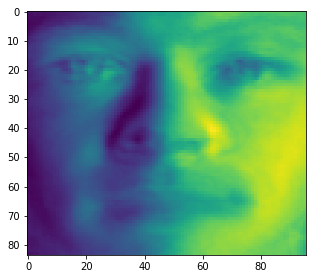

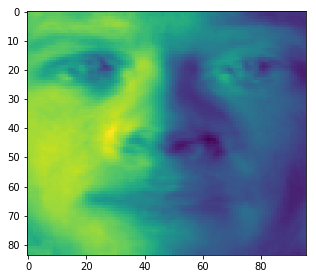

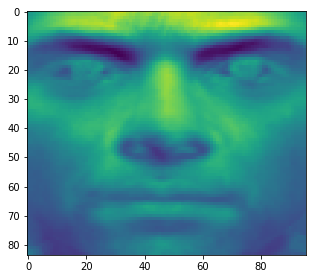

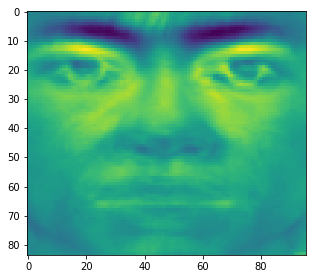

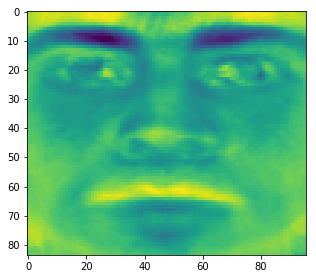

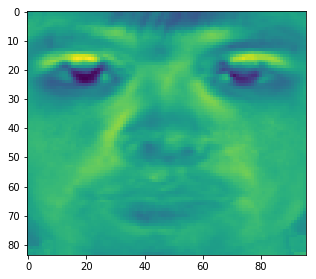

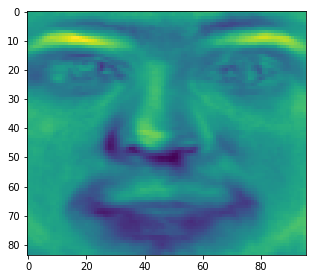

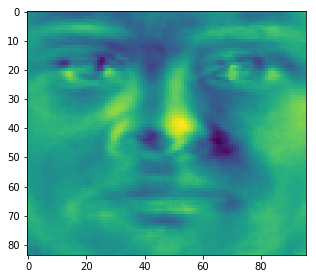

In [22]:
# Display first four eigenfaces
yalB_path = os.path.join('..', 'data', 'yaleB')
    
temp = train['01']
value = temp[0];
path = os.path.join(yalB_path,"yaleB01",value);
img = cv.imread(path);
h = img.shape[0];
w = img.shape[1];

components = pca.components_
for k in range(8):
    plt.subplots(1,1, figsize=(5, 5))
    component = components[k];
    shaped_cmp = component.reshape(int(w/2),int(h/2))
    plt.imshow(shaped_cmp)

With our fresh subspace computed we can try to visualize if it separates properly the different subjects. Having a proper plot of an $N$ dimensional space is not feasible, however, we can use only a few components (*i.e. 2 or 3*) of our projected samples to visualize them. 


What we want is a subspace that is able to separates and clusters properly each subject in order to avoid miss recognition. The code snippet below shows the $3^{rd}$ and $4^{th}$ components on a $2D$ plane.

What do you think about it, do we have clean inter-subject separation?

** Your answer **
- All the points form a big blob and there is no obvious clusters appearing. This is due to that fact that eigenvectors are not selected inorder to maximize the inter-class separability.  Hence the separation is not good on those components.

Text(0.5,1,'Trainset clusters')

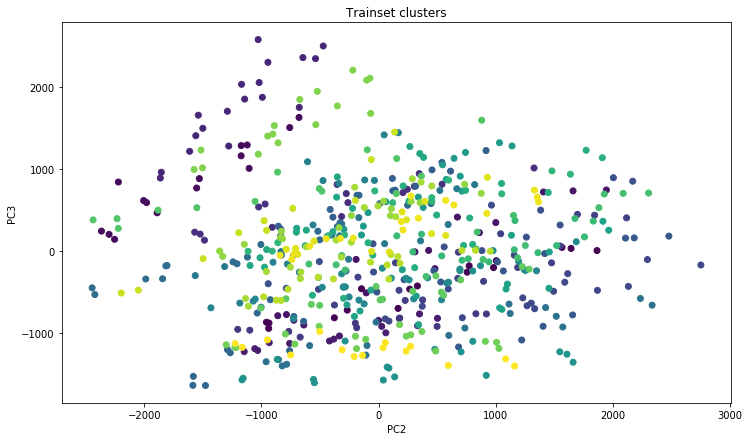

In [23]:
# Poject data onto subspace
proj_train = pca.transform(train_img)

# Visualize 
# Colors for distinct individuals
colors = LabelEncoder().fit_transform(train_label.ravel())

plt.figure(figsize=(12, 7))
plt.scatter(proj_train[:, 2], proj_train[:, 3], c=colors)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Trainset clusters')

With our learned subspace we need to defined the corresponding representation for the training samples. This can be done by projecting them into the eigen subspace (*i.e. eigenface*) as follow:

$$
\boldsymbol{\omega}_i = \boldsymbol{U}^\top \boldsymbol{\phi}_i
$$

In the training set, there are multiple samples avaible for each subject. Their projection won't be exactly the same, therefore we need to have a more generic representation of each person. To do so, we average all representation of the specific person to have his general representation.

$$
\boldsymbol{\Omega}_k = \frac{1}{N_k} \sum_{p} \boldsymbol{\omega}_p
$$

where $N_k$ is the number of samples for subject $k$, $\boldsymbol{\omega}_p$ represents the projected samples of subject $k$ respectively. In our case, $k$ goes from $0$ to $37$.

Now implement the function below that computes each subject's centroid, and returned their corresponding labels as well.

** Your answer **




In [24]:
def compute_centroids(data_full, trsfrm, label):
    """
    Given a list of training samples, compute the centroids of each uniques labels

    :param data:    Matrix with all feature vectors stored as row
    :param trsfrm:  Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param label:   List of corresponding labels
    :return:        Centroids, unique labels
    """


    # extract unique label
    unique_lbl = np.unique(label)
    
    # Your code goes here ...
    data = trsfrm.transform(data_full)
    
    centroids =np.zeros((len(unique_lbl),data.shape[1]));
    Nsamples = np.zeros((len(unique_lbl),1));
    
    NLine = data.shape[0];
    for line in range(NLine):
        ID_list = np.where(unique_lbl==label[line])
        ID = ID_list[0]
        centroids[ID,:] = centroids[ID,:] + data[line,:]; 
        Nsamples[ID,0] = Nsamples[ID,0]+1;
        
    # Labeling ecah sample
    for lbl in unique_lbl:
        ID_list = np.where(unique_lbl==lbl)
        ID = ID_list[0]
        for column in range(centroids.shape[1]):
            centroids[int(ID)-1,column] = centroids[int(ID)-1,column]/Nsamples[int(ID)-1,0];
            
    return centroids, unique_lbl

In [25]:
# Define centroids
train_centroids, train_centroid_label = compute_centroids(train_img, pca, train_label)
assert(train_centroids.shape[0] == 38)
assert(train_centroid_label.shape[0] == 38)

So far we've learned a face representation and computed the descriptor for the training samples. Now we can use them to recognize a face. To do so the first step is to bring the *new* sample into our face *subspace* by projection, similarly  to what has been done before:

$$
\boldsymbol{\omega}_n = \boldsymbol{U}^{\top}(\boldsymbol{I}_n - \bar{\boldsymbol{I}})
$$

where $U$ is the face subspace, $\bar{\boldsymbol{I}}$ is the average face learned from the training data and $\boldsymbol{I}_n$ is the new sample to recognize.

Once the sample is in the same subspace as the training samples, we can measure its **similarity** (*distance*) with the centroids $\boldsymbol{\Omega}_k$ computed before. The predicted label will be the one corresponding the closest centroid. 

$$ 
min \left|\left| \boldsymbol{\omega}_n - \boldsymbol{\Omega}_k \right|\right| \quad \forall k \in \{Train\}
$$

Using the prototype below implement a function that predicts each label of new samples.

** Your answer **


In [26]:
def recognize(trsfrm, centroids, centroids_label, samples):
    """
    Perform object recognition on a given list of ``amples

    :param trsfrm:          Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param centroids:       List of centroids learned in training phase
    :param centroids_label: Label corresponding to the centroids
    :param samples:         List of samples to recognize
    :return:                Predicted labels
    """

    # Define output container
    pred = np.zeros((samples.shape[0], 1), dtype=np.float32)

    # Your code goes here ...
    data = trsfrm.transform(samples);
    Nsamples = data.shape[0];
    for sampleID in range(Nsamples):
        score = [];
        for lbl in range(centroids_label.shape[0]):
            current_score = 0
            for feature in range(data.shape[1]):
                current_score = current_score + (centroids[lbl,feature]-data[sampleID,feature])**2;
            score.append(current_score);
        min_index = score.index(min(score));
        pred[sampleID,0] = centroids_label[min_index];
        
    
    # Done
    return pred

One way to validate the implementation is to try the whole system on the training set. The expected recognition accuracy should by close to 100% depending on the task difficulty.

In [27]:
# Recognize training set
pca_train_pred = recognize(pca, train_centroids, train_centroid_label, train_img)

# Compute performance
n_err = np.count_nonzero(np.where(pca_train_pred != train_label))
train_acc = 1.0 - n_err / train_label.size
print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))


The recognition accuracy on the trainig set is 0.92


Estimate the recognition accuracy on the testing set and comments on what you see

** Your answer **
- The accuracy is better on the training set, which seems natural since it is like doing self validation. However, the performance isn't degraded too badly on the testing set. This seems like a good result for the algorithm.

In [28]:
# Your code goes here ...

# Load testing images into memery
test_img, test_label = load_images(test)


# Recognize testing set
pca_test_pred = recognize(pca, train_centroids, train_centroid_label, test_img)

# Compute performance
n_err = np.count_nonzero(np.where(pca_test_pred != test_label))
train_acc = 1.0 - n_err / test_label.size
print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))

The recognition accuracy on the trainig set is 0.89


Measuring accuracy of the system is a good indicator of the overall performance but does not indicate where the system is performing poorly. This can be quantified using **Confusion Matrix**. It describes the performance of classification model and shows how the system is confused for each sample in the training set.

Such representation can be computed using `sklearn.metrics.confusion_matrix`, details are provided [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

** Your answer **
- Overall, the confusion matrix is diagonal (which means it is correct most of the time). Outside the diagonal, we can spot some cells with a higher score, which identify a couple of faces for which the algorithm is more likely to be wrong. It is interesting to see that this matrix is not necessarily symmetric. One face can be mistaken for another one but this doesn't imply that the algorithm won't work the other way around.

In [29]:
# Your code goes here ...
cm = confusion_matrix(pca_test_pred,test_label)
classes = train_centroid_label

Normalized confusion matrix


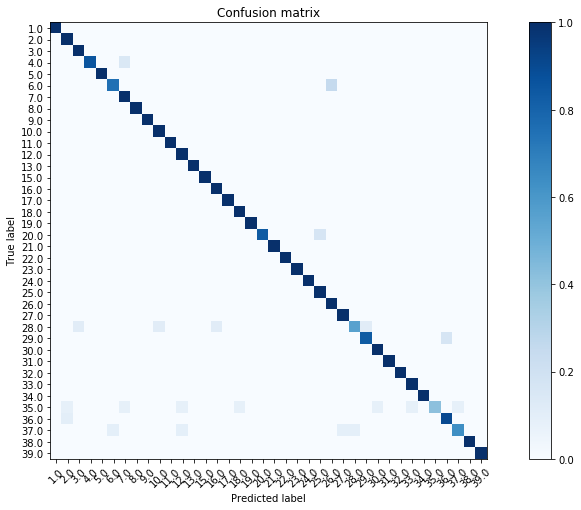

In [30]:
# Plot confusion matrix
plt.figure(figsize=(12, 7))
plot_confusion_matrix(cm, classes, normalize=True)

### Fisherface

The subspace computed before with *PCA* was looking at directions where the variation in the data is maximum without paying attention to the class each data point belongs to. Therefore this approach is unsupervised. The major drawback is that the class separability is not guaranteed to be optimum. 

The approach of *Linear Discriminant Analysis* is to find a subspace where the variation is large (*i.e. similar to PCA*) but also to maximize the inter-class separability by taking into account each sample's label. The figure below shows an example:

<img src="../data/lda_example.png" alt="Drawing" style="width: 400px;"/>

Such subspace can be computed as follow:

- Compute the scatter matrices (*intra-classes* / *inter-classes*)
- Compute the eigenvectors / eigenvalues
- Select the $K_m$ largest eigenvalues and their corresponding eigenvectors

Given a set of samples $\boldsymbol{I}_0, \dots, \boldsymbol{I}_N$ and their corresponding labels $y_0, \dots, y_N$, the intra-class scatter matrix is computed as follow:

$$
\boldsymbol{S}_w = \sum_{i=1}^N \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right) \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right)^{\top}
$$

where $\boldsymbol{\mu}_{k}$ is the sample mean of the $k^{th}$ class.
Then the inter-class scatter matrix is defined as:

$$
\boldsymbol{S}_b = \sum_{k=1}^{m} n_k (\boldsymbol{\mu}_k - \boldsymbol{\mu})(\boldsymbol{\mu}_k - \boldsymbol{\mu})^{\top}
$$

where $m$ is the number of classes, $\boldsymbol{\mu}$ is the overall sample average and $n_k$ is the number of samples in the $k^{th}$ class.

Finally the subspace $\boldsymbol{W}$ can be computed by solving the following generalizeed eigenvalue problem:

$$
\boldsymbol{S}_b \boldsymbol{W} = \lambda \boldsymbol{S}_w \boldsymbol{w}
$$

Finally at most $m-1$ generalized eigenvectors are useful to discriminate between $m$ classes.

In practice, such decomposition can be computed using `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`, more information available [here](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

Now compute the *LDA* subspace similar to what you have done before and display the first 8 bases (*i.e. Fisherface*).

**Your answer **
- The fischerfaces seem to emphasis on specific features of each faces. For instances, some part of the eyes have high coefficients. Those specific areas are probably features that make a bigger difference when comparing different people. Thus, it is better than eigenfaces. 

In [31]:
# Compute FisherFaces with LDA
n_component = 37;
# Compute Eigenfaces
lda = LDA(n_components=n_component) 
lda.fit(train_img,train_label.ravel())

C:\Users\agadg\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=37, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

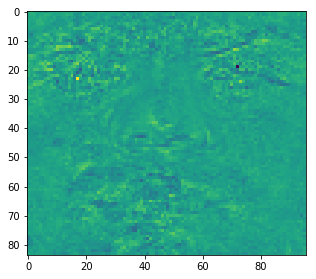

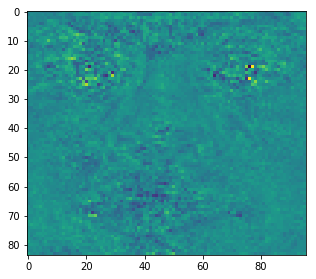

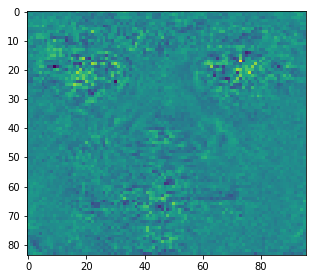

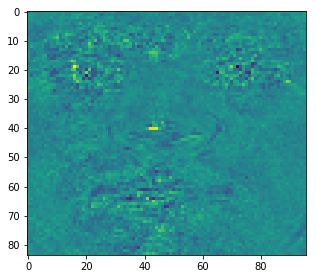

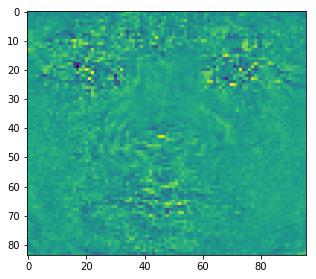

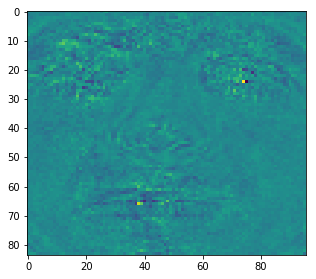

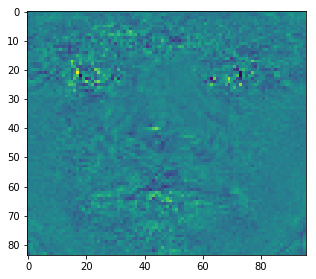

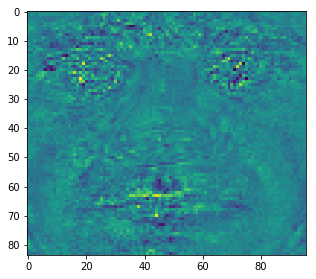

In [32]:
# Get basis
# Display first four fischerfaces
components = lda.coef_
for k in range(8):
    plt.subplots(1,1, figsize=(5, 5))
    component = components[k];
    shaped_cmp = component.reshape(int(w/2),int(h/2))
    plt.imshow(shaped_cmp)


Similar to what we have done before visualize the subspace created by the *LDA* decomposition. 

What do you see, is it better than before ?

** Your answer **
- From the projection visualized below, we can clearly see that points are clustered by colors. The segmentation would be easier than previous one. Still, the two dimensions we plotted wouldn't be enough to do the segmentation, but it is on a good way.


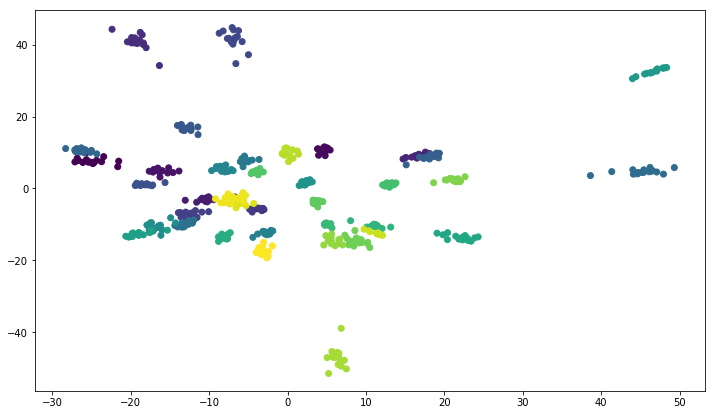

In [33]:
# Poject data onto subspace
proj_train = lda.transform(train_img)

# Visualize 
plt.figure(figsize=(12, 7))
plt.scatter(proj_train[:, 2], proj_train[:, 3], c=colors)
plt.show()

Based on what has been done before, compute the recognition accuracy on the *training*/testing* set for the *LDA* recognizer.

** Your answer **

In [34]:
# Your code goes here ...
# Define centroids
train_centroids, train_centroid_label = compute_centroids(train_img, lda, train_label)
assert(train_centroids.shape[0] == 38)
assert(train_centroid_label.shape[0] == 38)

# Recognize training set
lda_train_pred = recognize(lda, train_centroids, train_centroid_label, train_img)

# Compute performance
n_err = np.count_nonzero(np.where(lda_train_pred != train_label))
train_acc = 1.0 - n_err / train_label.size
print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))

# Recognize training set
lda_test_pred = recognize(lda, train_centroids, train_centroid_label, test_img)

# Compute performance
n_err = np.count_nonzero(np.where(lda_test_pred != test_label))
test_acc = 1.0 - n_err / test_label.size
print("The recognition accuracy on the testing set is {:.2f}".format(test_acc))

The recognition accuracy on the trainig set is 1.00
The recognition accuracy on the testing set is 1.00


Compute the *Confusion Matrix* and comment on the result you have

** Your answer **
- This time the confusion matrix is almost perfect to diagonal symmetric matrix. There is no cell with higher scores outside of the diagonal part of the matrix. The result of the confusion matrix is reasonable since the recognition accuracies on both training and testing set are 1. This means that this algorithm is very powerful in identifying the different faces. 

Normalized confusion matrix


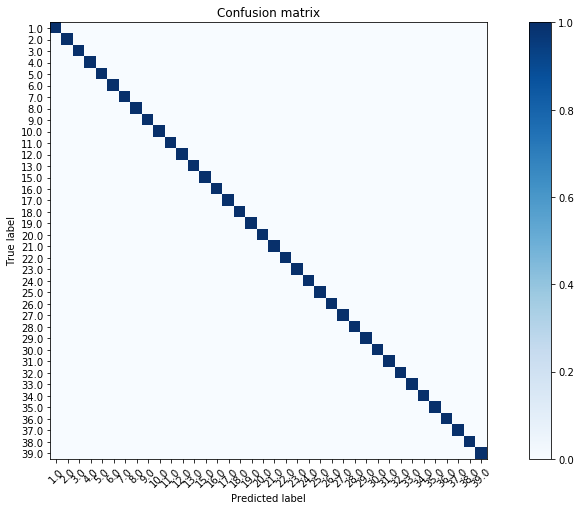

In [35]:
# Your code goes here ...
cm = confusion_matrix(lda_test_pred,test_label)
classes = train_centroid_label
# Plot confusion matrix
plt.figure(figsize=(12, 7))
plot_confusion_matrix(cm, classes, normalize=True)

You have implemented / tested two approaches for face recognition which one works the best and why ? What's are the pro/cons of each method ?

** Your answer **
- The major drawback of the pca approach is that it is unsupervised. Therefore, it doesn't take advantage of the knowledge of the label in the subspace computation. This is what leads to the lower performance. The LDA approach provides better results, even with a smaller subspace because it focuses more on points that really create a difference between subjects. Both methods have limitations in terms of scaling and pre-processing of the images.